# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [545]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [546]:
#os.chdir("..")
current_working_dir = os.getcwd()
# print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

In [547]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [548]:
# def makeFilePath(pathFromWorkspace, fileName):
#     workingdir = "/workspace/" if (os.name != "nt") else ""
#     filepath = workingdir+pathFromWorkspace+fileName

#     return filepath

In [549]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [550]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq /1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [551]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [552]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

## 1- Data Preparation

In [553]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation.csv.gz')
data.shape

(200000, 79)

In [554]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,urti_date_1,urti_date_2,...,hemiplegia_comor,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id
count,10000,20000,150000,20000,20000,20000,20000,60000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
unique,1222,699,41,41,41,13,13,1222,1222,1222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2021-11-05,2022-04-17,2020-07,2019-09,2021-07,2018-10,2018-05,2021-07-25,2021-02-14,2020-04-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,18,162,3900,536,537,1764,1774,73,29,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,9.991527e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,5.772297e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.100000e+01
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.968908e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.988445e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.498292e+06


### 1-2- Additional variables
#### 1-2-1- Calculating CHarlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [555]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [556]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    # if data.iat[idx, col4] == 1: # heart_failure_comor############################
    #     n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia#########################################
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma#########################################
    #    n=n+2

    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3

    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

2.0     26390
3.0     25656
1.0     23840
4.0     23584
0.0     19041
5.0     17523
6.0     15843
7.0     12533
8.0      9621
9.0      7598
10.0     6165
11.0     4276
12.0     3001
13.0     1958
14.0     1181
15.0      737
16.0      468
17.0      272
18.0      160
19.0       81
20.0       49
21.0       12
22.0       10
24.0        1
Name: CCI, dtype: int64

#### 1-2-2- Calculating all meds except abs

In [557]:
#generate meds_noabs in the one month before
data['meds_nonabs'] = data['all_meds'] - data['antibacterial_brit']

# assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

data['meds_nonabs'].value_counts()
# data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

0    133162
2     22260
3     18835
1     17349
4      7187
5      1141
6        65
7         1
Name: meds_nonabs, dtype: int64

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [558]:
#dropping any variable with more than 50 percent missing values
perc = 50.0
data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].loc[:, data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].isnull().mean() < perc]
data.shape

(200000, 81)

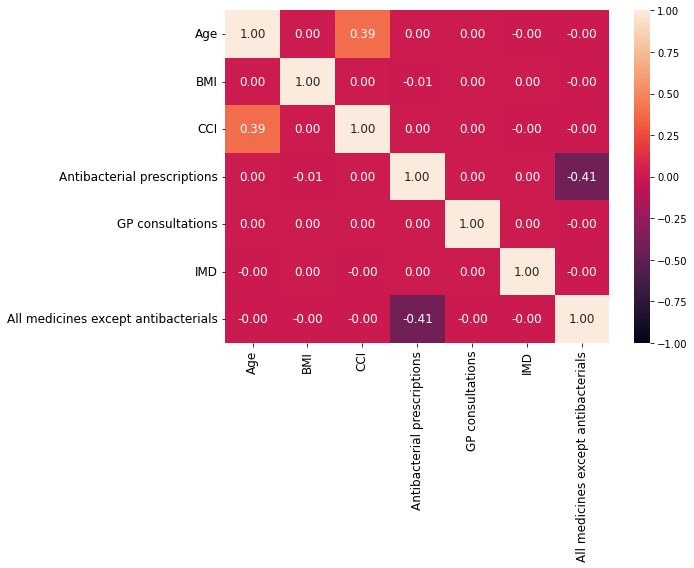

In [559]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

In [560]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = 0

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data['antibacterial_brit'][data['antibacterial_brit'] < 0] = np.nan

In [561]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data = data.replace({"sex": dict_sex})
data = data.replace({"smoking_status": dict_smoking})

In [562]:
if ('bmi' in data.columns) and (data['bmi'].isnull().sum() > 0):
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
    # imputer.fit(data[['age', 'sex', 'bmi']])
    imputer.fit(data[['age', 'sex', 'CCI', 'bmi']])# 'CCI']])
    # data['bmi_imp'] = np.nan
    # data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'bmi']]))[:,2]
    data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]
elif ('bmi' in data.columns) and (data['bmi'].isnull().sum() == 0):
    data['bmi_imp'] = data['bmi']

# 
print(f'Count of missing values in variable bmi: {data.bmi.isnull().sum()}')
print(f'Mean of bmi values: {data.bmi.mean():.3f}')
print(f'Max of bmi values: {data.bmi.max():.3f}')
print(f'Min of bmi values: {data.bmi.min():.3f}')
print(f'Count of missing values in variable bmi after imputation: {data.bmi_imp.isnull().sum()}')
print(f'Mean of bmi values after imputation: {data.bmi_imp.mean():.3f}')
print(f'Max of bmi values after imputation: {data.bmi_imp.max():.3f}')
print(f'Min of bmi values after imputation: {data.bmi_imp.min():.3f}')

Count of missing values in variable bmi: 0
Mean of bmi values: 26.242
Max of bmi values: 77.457
Min of bmi values: 0.000
Count of missing values in variable bmi after imputation: 0
Mean of bmi values after imputation: 26.242
Max of bmi values after imputation: 77.457
Min of bmi values after imputation: 0.000


In [563]:
if ('imd' in data.columns) and (data['imd'].isnull().sum() > 0):
    data['imd'] = data['imd'].astype(str)
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
    imputer.fit(data[['age', 'sex', 'CCI', 'imd']])#'bmi_imp']])
    # data['imd_imp'] = np.nan
    data['imd_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'imd']]))[:,3]
    # data['imd_imp'] = data['imd_imp'].astype(str)
elif ('imd' in data.columns) and (data['imd'].isnull().sum() == 0):
    data['imd_imp'] = data['imd']
    # data['imd_imp'] = data['imd_imp'].astype(str)

print(f'Cound of missing values in variable imd: {data.imd.isnull().sum()}')
print(f'Count of categories of variable imd: \n{data.imd.value_counts()}')
print(f'\nCound of missing values in variable imd after imputation: {data.imd_imp.isnull().sum()}')
print(f'Count of categories of variable imd after imputation: \n{data.imd_imp.value_counts()}')

Cound of missing values in variable imd: 0
Count of categories of variable imd: 
4    38267
2    38165
3    37884
1    37814
5    37774
0    10096
Name: imd, dtype: int64

Cound of missing values in variable imd after imputation: 0
Count of categories of variable imd after imputation: 
4    38267
2    38165
3    37884
1    37814
5    37774
0    10096
Name: imd_imp, dtype: int64


In [564]:
if ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() > 0):
    data['smoking_status'] = data['smoking_status'].astype(str)
    # data['smoking_status_imp'] = data['smoking_status'].replace(np.nan, 0)
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
    imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']])#'imd']]) # 'imd_imp'
    # data['smoking_status_imp'] = np.nan
    data['smoking_status_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']]))[:,4]
    # data['smoking_status_imp'] = data['smoking_status_imp'].astype(str)
elif ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() == 0):
    data['smoking_status_imp'] = data['smoking_status']
    # data['smoking_status_imp'] = data['smoking_status_imp'].astype(str)

print(f'Cound of missing values in variable smoking_status: {data.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status: \n{data.smoking_status.value_counts()}')
print(f'\nCound of missing values in variable smoking_status after imputation: {data.smoking_status_imp.isnull().sum()}')
print(f'Count of categories of variable smoking_status after imputation: \n{data.smoking_status_imp.value_counts()}')

Cound of missing values in variable smoking_status: 0
Count of categories of variable smoking_status: 
nan    83028
1.0    77821
3.0    26242
2.0    12909
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after imputation: 0
Count of categories of variable smoking_status after imputation: 
2.0    95937
1.0    77821
3.0    26242
Name: smoking_status_imp, dtype: int64


In [565]:
if ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() > 0):
    data['ethnicity'] = data['ethnicity'].astype(str)
    # data['ethnicity_imp'] = data['ethnicity'].replace(np.nan, 0)
    # # iterative imputation with sklearn package
    imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
    imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']])# 'smoking_status_imp']]) #'imd_imp'
    # data['ethnicity_imp'] = np.nan
    data['ethnicity_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']]))[:,5] #'imd_imp'
    # data['ethnicity_imp'] = data['ethnicity_imp'].astype(str)
elif ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() == 0):
    data['ethnicity_imp'] = data['ethnicity']
    # data['ethnicity_imp'] = data['ethnicity_imp'].astype(str)

print(f'Cound of missing values in variable ethnicity: {data.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity: \n{data.ethnicity.value_counts()}')
print(f'\nCound of missing values in variable ethnicity after imputation: {data.ethnicity_imp.isnull().sum()}')
print(f'Count of categories of variable ethnicity after imputation: \n{data.ethnicity_imp.value_counts()}')

Cound of missing values in variable ethnicity: 0
Count of categories of variable ethnicity: 
1.0    119779
nan     50000
3.0     15129
5.0     15092
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after imputation: 0
Count of categories of variable ethnicity after imputation: 
1.0    119779
2.0     50000
3.0     15129
5.0     15092
Name: ethnicity_imp, dtype: int64


In [566]:
if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() > 0):
    # # iterative imputation with sklearn package
    # imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
    # imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'gp_count']])# 'ethnicity_imp']]) # 'imd_imp'
    # # data['gp_count_imp'] = np.nan
    # data['gp_count_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'gp_count']]))[:,3] #'imd_imp'
    # drop gp_count value missing
    data['gp_count_imp'] = data['gp_count']
    data = data[data['gp_count_imp'].notna()]
elif ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() == 0):
    data['gp_count_imp'] = data['gp_count']

print(f'Cound of missing values in variable gp_count: {data.gp_count.isnull().sum()}')
print(f'Mean of gp_count values: {data.gp_count.mean():.3f}')
print(f'\nCound of missing values in variable gp_count after imputation: {data.gp_count_imp.isnull().sum()}')
print(f'Mean of gp_count values after imputation: {data.gp_count_imp.mean():.3f}')

Cound of missing values in variable gp_count: 0
Mean of gp_count values: 3.344

Cound of missing values in variable gp_count after imputation: 0
Mean of gp_count values after imputation: 3.344


In [567]:
if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']])# 'gp_count']]) #'imd_imp'
#     # data['antibacterial_brit_imp'] = np.nan
#     data['antibacterial_brit_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']]))[:,7] # 'imd_imp'
    # drop antibacterial_brit value missing
    data['antibacterial_brit_imp'] = data['antibacterial_brit']
    data = data[data['antibacterial_brit_imp'].notna()]
elif ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() == 0):
    data['antibacterial_brit_imp'] = data['antibacterial_brit']

print(f'Cound of missing values in variable antibacterial_brit: {data.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values: {data.antibacterial_brit.mean():.3f}')
print(f'\nCound of missing values in variable antibacterial_brit after imputation: {data.antibacterial_brit_imp.isnull().sum()}')
print(f'Mean of antibacterial_brit values after imputation: {data.antibacterial_brit_imp.mean():.3f}')

Cound of missing values in variable antibacterial_brit: 0
Mean of antibacterial_brit values: 1.252

Cound of missing values in variable antibacterial_brit after imputation: 0
Mean of antibacterial_brit values after imputation: 1.252


In [568]:
if ('region' in data.columns) and (data['region'].isnull().sum() > 0):
#     # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity_imp', 'region']])
#     # data['region_imp'] = np.nan
#     data['region_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity_imp', 'region']]))[:,7] # 'imd_imp'
    # drop region value missing
    data['region_imp'] = data['region']
    data = data[data['region_imp'].notna()]
elif ('region' in data.columns) and (data['region'].isnull().sum() == 0):
    data['region_imp'] = data['region']

print(f'Cound of missing values in variable region: {data.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data.region.value_counts()}')
print(f'\nCound of missing values in variable region after imputation: {data.region_imp.isnull().sum()}')
print(f'Count of categories of variable region after imputation: \n{data.region_imp.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      39676
Yorkshire and The Humber    19998
East Midlands               19954
West Midlands               19906
East                        19904
South West                  19870
South East                  19863
North West                  19852
North East                  19784
Name: region, dtype: int64

Cound of missing values in variable region after imputation: 0
Count of categories of variable region after imputation: 
London                      39676
Yorkshire and The Humber    19998
East Midlands               19954
West Midlands               19906
East                        19904
South West                  19870
South East                  19863
North West                  19852
North East                  19784
Name: region_imp, dtype: int64


### 1-4- Translating states with dictionaries

In [569]:
# define dictionaries
dict_sex = {0: 'Female', 1: 'Male'}
# dict_bmi_imp_cat = {'Underweight': 'Underweight', 'Healthy weight': 'Healthy weight', 'Overweight': 'Overweight', 'Obese': 'Obese', 
#                 np.nan: 'Unknown'}
# dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
# dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_ethnicity_imp = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown'}
# dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked'}
dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked', 0: 'Unknown'}
# dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
# dict_smoking_status= {'Smoker': 'Smoker', 'Never smoked': 'Never smoked', 'Ex-smoker': 'Ex-smoker', 'Unknown': 'Unknown', 
#                        np.nan: 'Unknown'}
# dict_gp_count_imp_cat = {'Few': 'Few', 'Some': 'Some', 'Many': 'Many', 'Too many': 'Too many', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [570]:
# reoplace values of dictionaries with existing ones
data = data.replace({"sex": dict_sex})
# data = data.replace({"bmi_imp_cat": dict_bmi_imp_cat})
# data = data.replace({"imd": dict_imd_imp})
data = data.replace({"ethnicity_imp": dict_ethnicity_imp})
data = data.replace({"smoking_status_imp": dict_smoking_imp})
# data = data.replace({"smoking_status": dict_smoking_status})
# data = data.replace({"gp_count_imp_cat": dict_gp_count_imp_cat})
data = data.replace({"flu_vaccine": dict_flu})

In [571]:
# categorising
data['bmi_imp_cat'] = pd.cut(data['bmi_imp'], right=False, bins=[0,18.5,25,30,10000000000], labels=['Underweight', 'Healthy weight', 'Overweight', 'Obese'])
data['gp_count_imp_cat'] = pd.cut(data['gp_count_imp'], right=False, bins=[0,3,8,10000000000], labels=['Few', 'Some', 'Many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,10000000000], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,10000000000], labels=['0-17 years', '18-59 years', '>59 years'])

data['antibacterial_brit_cat'] = pd.cut(data['antibacterial_brit_imp'], right=False, bins=[0,2,6,10000000000], labels=['Few', 'Some', 'Many'])
data['meds_nonabs_cat'] = pd.cut(data['meds_nonabs'], right=False, bins=[0,2,6,10000000000], labels=['Few', 'Some', 'Many'])

### 1-5- Polynimial featuring

## 2- Plots
### 2-1- Continuous factors

In [572]:
# fig, axes = plt.subplots(3,2, 
#                         figsize=(15, 15)
#                         )
# create_histplot('BMI', data['bmi'], axes[0,0])
# create_histplot('Age', data['age'], axes[0,1])
# create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
# create_histplot('Practice', data['practice'], axes[1,1])
# create_histplot('CCI', data['CCI'], axes[2,0])
# fig.delaxes(ax=axes[2,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont.jpg')
# plt.show()

In [573]:
# p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
#                              ], 
#                 hue = 'admitted', # 'antibacterial_brit', 
# #                kind='reg', 
#                 #markers=["o", "s"], 
#                 diag_kind="kde",#"hist"
# #                plot_kws={#'line_kws':{'color':'red'}, 
#                 plot_kws={'alpha':0.3},
#                 height = 3)

# p.axes[0,2].set_xlim((0,20))
# p.axes[0,2].set_ylim((0,100))

# p.axes[1,1].set_xlim((0,75))
# p.axes[1,1].set_ylim((0,75))

# p.axes[2,0].set_xlim((0,100))
# p.axes[2,0].set_ylim((0,20))

# p.axes[0,3].set_xlim((0,20))
# p.axes[3,0].set_ylim((0,20))

# plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont_pairplot.jpg')
# plt.show()

### 2-2- Categorical factors

In [574]:
# fig, axes = plt.subplots(7,2,
#                         figsize=(15, 10)
#                         )
# create_lineplot(data, 'sex', 'Sex', 'Sex', axes[0,0])
# create_lineplot(data, 'age_cat', 'Age category', 'Age category', axes[0,1])
# create_lineplot(data, 'imd_imp', 'IMD', 'IMD', axes[1,0])
# create_lineplot(data, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
# create_lineplot(data, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
# create_lineplot(data, 'bmi_imp_cat', 'BMI', 'BMI', axes[2,1])
# create_lineplot(data, 'CCI_cat', 'CCI', 'CCI', axes[1,0])
# create_lineplot(data, 'gp_count_imp_cat', 'GP consultation', 'GP consultation', axes[3,1])
# create_lineplot(data, 'region', 'Region', 'Region', axes[4,0])
# create_lineplot(data, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data, 'antibacterial_brit_imp', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data, 'msoa', 'msoa', 'MSOA', axes[5,1])
# create_lineplot(data, 'meds_nonabs', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[6,0])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat.jpg')
# plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- URTI

#### URTI-1

In [575]:
data_urti_1 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
                    'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1']]

data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

data_urti_1.shape

(19883, 31)

In [576]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_1
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
data_urti_1.shape

(17954, 31)

In [577]:
data_urti_1.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
       'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1',
       'sgss_gp_cov_urti_date_1'],
      dtype='object')

In [578]:
# drop rows with no gp_cons_urti_1 records
data_urti_1 = data_urti_1.dropna(subset=['gp_cons_urti_1'])
data_urti_1.shape

(1767, 31)

#### URTI-2

In [579]:
data_urti_2 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
                    'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2']]

data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

data_urti_2.shape

(19881, 31)

In [580]:
data_urti_1.urti_date_1.value_counts()

2021-08-12    7
2021-02-14    6
2020-03-29    6
2022-04-07    6
2019-03-11    6
             ..
2022-02-03    1
2021-09-04    1
2022-03-04    1
2020-08-21    1
2021-12-17    1
Name: urti_date_1, Length: 943, dtype: int64

In [581]:
data_urti_2.urti_date_2.value_counts()

2020-04-19    30
2021-03-13    30
2019-12-14    28
2020-09-18    28
2021-09-07    27
              ..
2021-04-11     7
2021-12-01     7
2021-10-17     6
2022-01-16     6
2021-11-08     5
Name: urti_date_2, Length: 1222, dtype: int64

In [582]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_2
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
data_urti_2.shape

(17883, 31)

In [583]:
data_urti_2.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
       'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2',
       'sgss_gp_cov_urti_date_2'],
      dtype='object')

In [584]:
# drop rows with no gp_cons_urti_2 records
data_urti_2 = data_urti_2.dropna(subset=['gp_cons_urti_2'])
data_urti_2.shape

(1799, 31)

#### URTI_3

In [585]:
data_urti_3 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
                    'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3']]

data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

data_urti_3.shape

(19876, 31)

In [586]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_urti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
data_urti_3.shape

(17885, 31)

In [587]:
data_urti_3.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
       'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3',
       'sgss_gp_cov_urti_date_3'],
      dtype='object')

In [588]:
# drop rows with no gp_cons_urti_3 records
data_urti_3 = data_urti_3.dropna(subset=['gp_cons_urti_3'])
data_urti_3.shape

(1834, 31)

#### URTI_4

In [589]:
data_urti_4 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
                    'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4']]

data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

data_urti_4.shape

(19892, 31)

In [590]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_4
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
data_urti_4.shape

(17878, 31)

In [591]:
data_urti_4.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
       'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4',
       'sgss_gp_cov_urti_date_4'],
      dtype='object')

In [592]:
data_urti_4.shape

(17878, 31)

In [593]:
# data_urti_4.gp_cons_urti_4.value_counts()#isnull().sum()
data_urti_4.gp_cons_urti_4.isnull().sum()

16049

In [594]:
# drop rows with no gp_cons_urti_4 records
data_urti_4 = data_urti_4.dropna(subset=['gp_cons_urti_4'])
data_urti_4.shape

(1829, 31)

#### Combining URTI_1, URTI_2, URTI_3, and URTI_4

In [595]:
data_urti_1.rename(columns={'urti_date_1': 'urti_date',
                           'gp_cons_urti_1': 'gp_cons_urti', 'gp_cons_urti_ab_1': 'gp_cons_urti_ab',
                           'incdt_urti_date_1': 'incdt_urti_date', #'prevl_urti_date_1': 'prevl_urti_date',
                           'admitted_urti_date_1': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_2.rename(columns={'urti_date_2': 'urti_date',
                           'gp_cons_urti_2': 'gp_cons_urti', 'gp_cons_urti_ab_2': 'gp_cons_urti_ab',
                           'incdt_urti_date_2': 'incdt_urti_date', #'prevl_urti_date_2': 'prevl_urti_date', 
                           'admitted_urti_date_2': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_3.rename(columns={'urti_date_3': 'urti_date',
                           'gp_cons_urti_3': 'gp_cons_urti', 'gp_cons_urti_ab_3': 'gp_cons_urti_ab',
                           'incdt_urti_date_3': 'incdt_urti_date', #'prevl_urti_date_3': 'prevl_urti_date', 
                           'admitted_urti_date_3': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'},
                 inplace=True)
data_urti_4.rename(columns={'urti_date_4': 'urti_date', 
                           'gp_cons_urti_4': 'gp_cons_urti', 'gp_cons_urti_ab_4': 'gp_cons_urti_ab',
                           'incdt_urti_date_4': 'incdt_urti_date', #'prevl_urti_date_4': 'prevl_urti_date',
                           'admitted_urti_date_4': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, 
                 inplace=True)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(7229, 31)

In [596]:
data_urti_4.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date'],
      dtype='object')

In [597]:
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['gp_cons_urti'] = data_urti['gp_cons_urti'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')
data_urti.shape

(7229, 31)

In [598]:
#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['gp_cons_urti']
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

In [599]:
#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['Spring', 'Summer', 'Autumn']
data_urti['season'] = np.select(conditions, choices, default='Winter')

data_urti['season'].value_counts()

Spring    2001
Winter    1958
Autumn    1646
Summer    1624
Name: season, dtype: int64

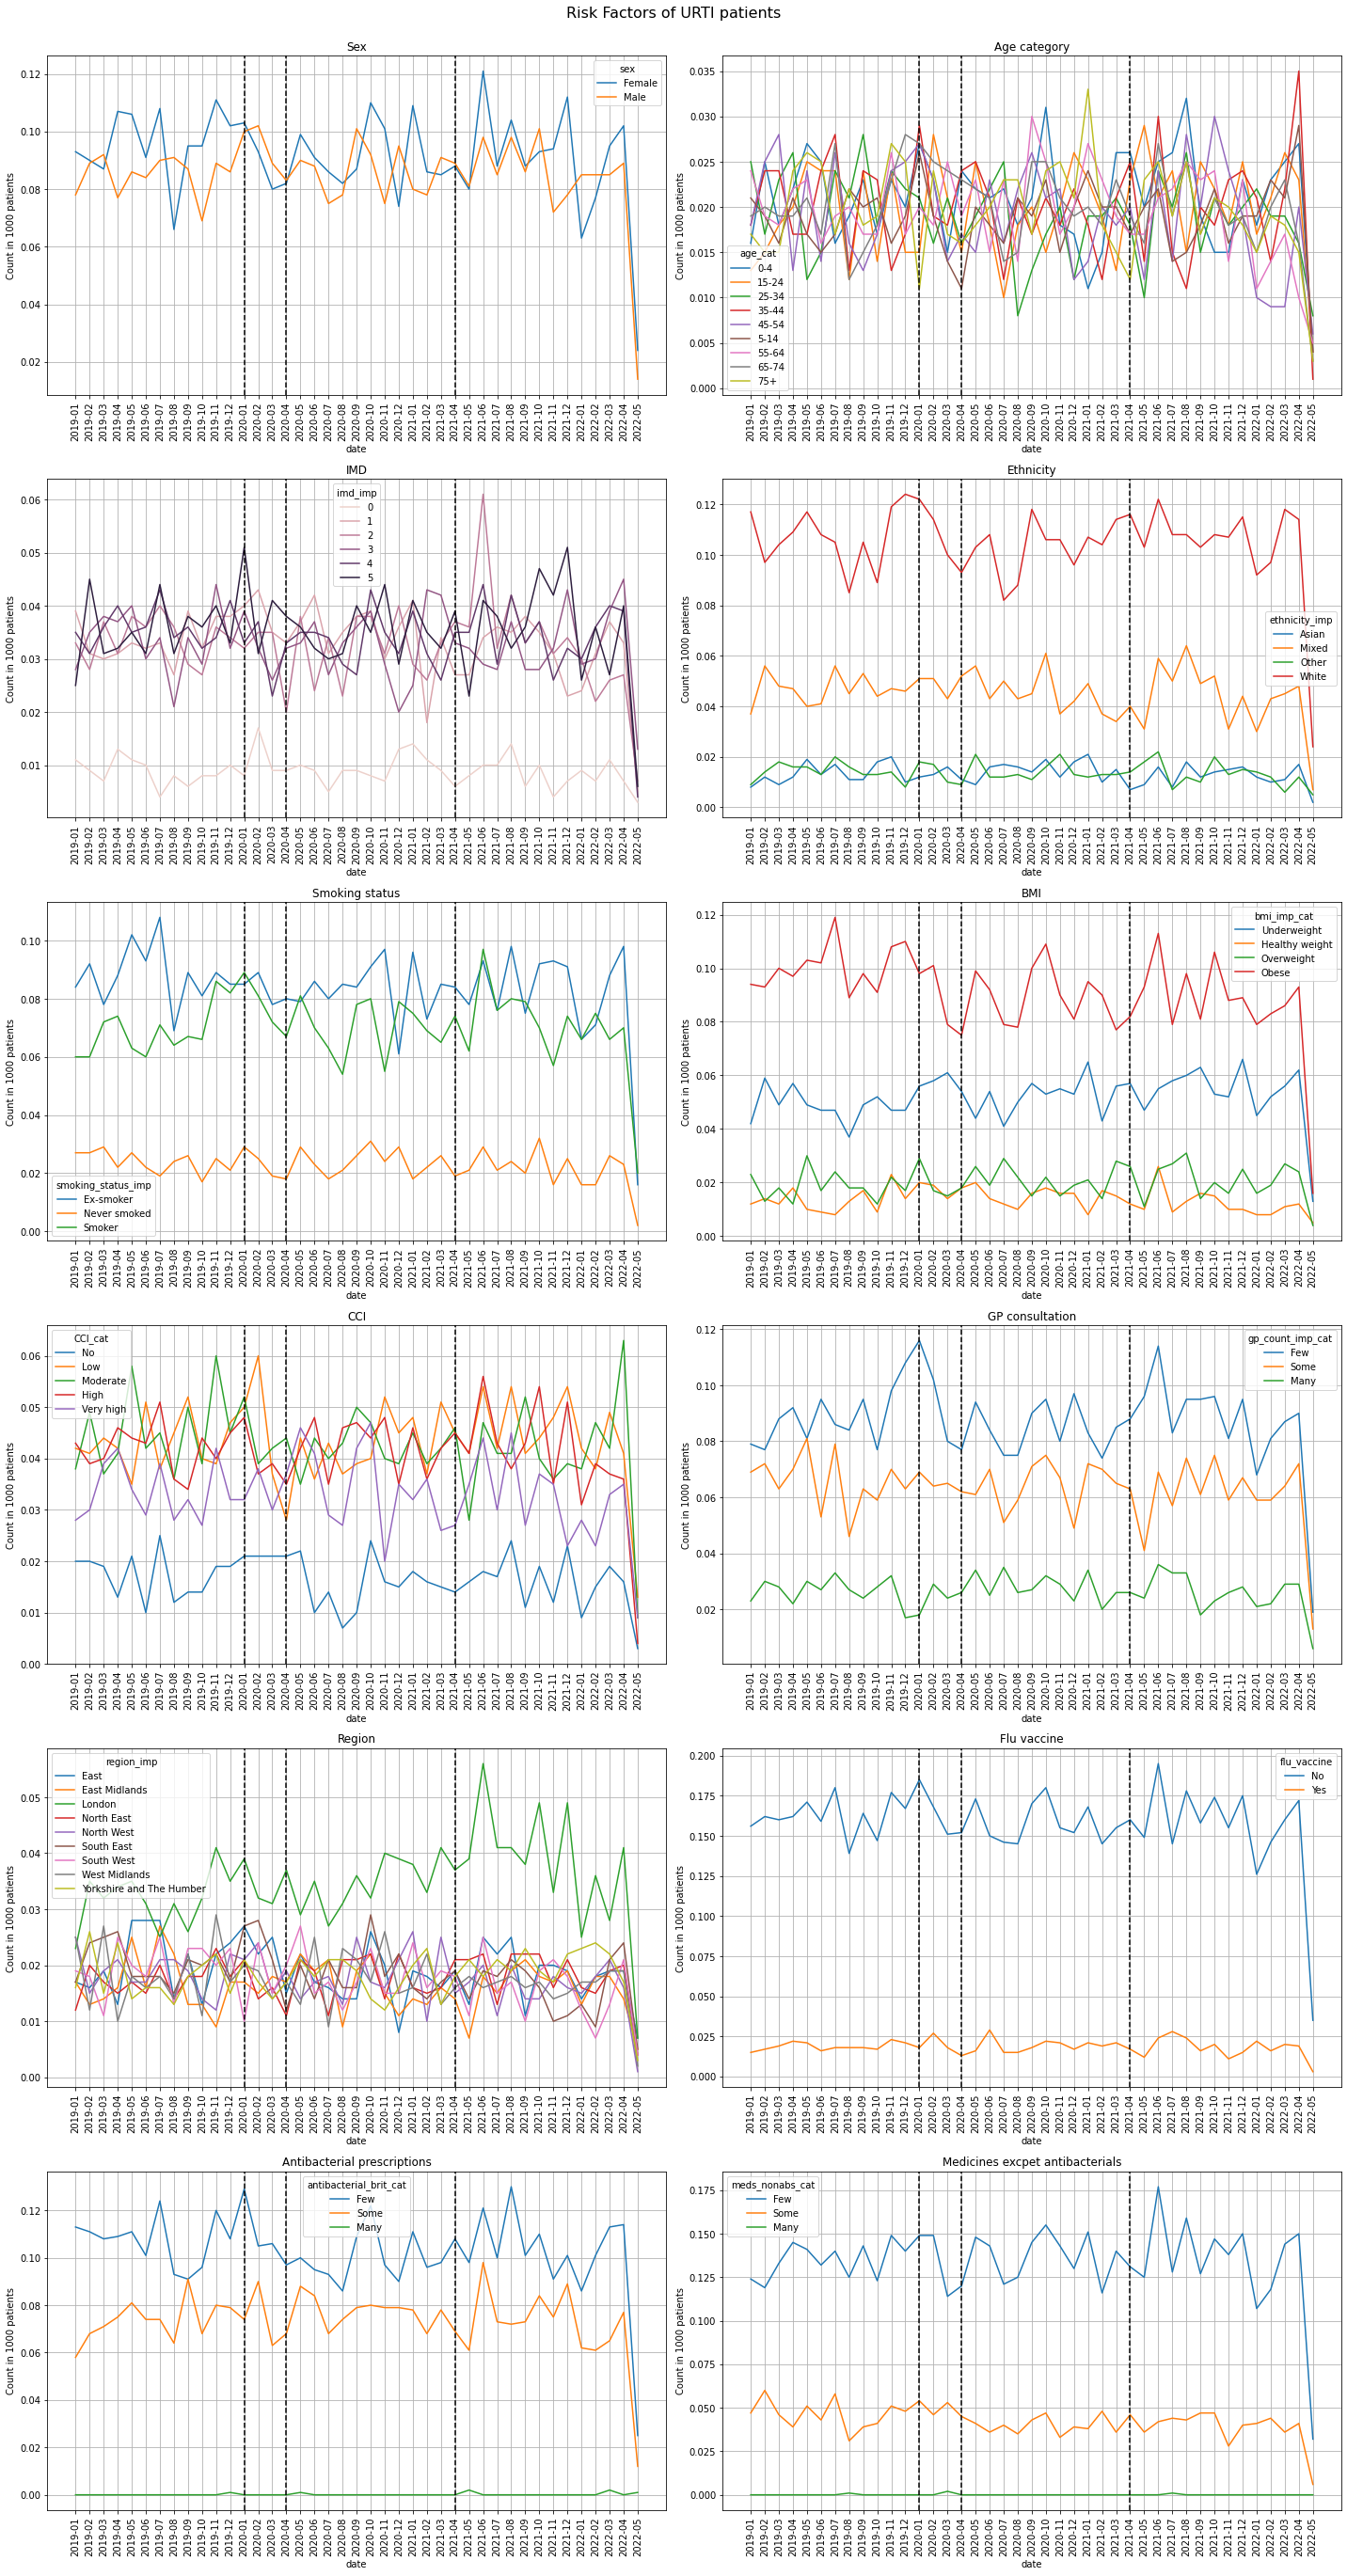

In [600]:
fig, axes = plt.subplots(6,2,
                        figsize=(20, 40)
                        )
create_lineplot(data_urti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_urti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_urti, 'imd_imp', 'IMD', axes[1,0])
create_lineplot(data_urti, 'ethnicity_imp', 'Ethnicity', axes[1,1])
create_lineplot(data_urti, 'smoking_status_imp', 'Smoking status', axes[2,0])
create_lineplot(data_urti, 'bmi_imp_cat', 'BMI', axes[2,1])
create_lineplot(data_urti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_urti, 'gp_count_imp_cat', 'GP consultation', axes[3,1])
create_lineplot(data_urti, 'region_imp', 'Region', axes[4,0])
create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', axes[4,1])
create_lineplot(data_urti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[5,0])
create_lineplot(data_urti, 'meds_nonabs_cat', 'Medicines excpet antibacterials', axes[5,1])
# fig.delaxes(ax=axes[6,1])

fig.suptitle('Risk Factors of URTI patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
plt.show()

#### Adding event and duration columns

In [601]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5060
Name: event_urti_admitted, dtype: int64

In [602]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['gp_cons_urti']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    5060
1.0      54
Name: event_urti_admitted, dtype: int64

In [603]:
#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

19.0      5
130.0     5
115.0     5
255.0     5
189.0     5
         ..
894.0     1
1130.0    1
559.0     1
134.0     1
382.0     1
Name: delta_urti_admitted, Length: 656, dtype: int64

In [604]:
# data_urti['event_urti_admitted'].value_counts()
data_urti['event_urti_admitted'].isnull().sum()

1029

In [605]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5065
1.0      54
Name: event_urti_admitted, dtype: int64

In [606]:
#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5065
1.0      54
Name: event_urti_admitted, dtype: int64

In [607]:
#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

6036

In [608]:
data_urti['delta_admitted_died_deregistered'].value_counts()

370.0    2
168.0    2
112.0    2
208.0    2
421.0    2
        ..
79.0     1
230.0    1
134.0    1
840.0    1
406.0    1
Name: delta_admitted_died_deregistered, Length: 99, dtype: int64

In [609]:
#censor patients that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0

In [610]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    6089
1.0      54
Name: event_urti_admitted, dtype: int64

In [611]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    6089
13.0       5
10.0       5
19.0       5
26.0       4
4.0        4
3.0        4
23.0       3
21.0       3
2.0        3
16.0       2
1.0        2
24.0       2
25.0       2
5.0        2
8.0        2
15.0       1
18.0       1
6.0        1
17.0       1
9.0        1
29.0       1
Name: duration_urti_admitted, dtype: int64

In [612]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    6089
1.0      54
Name: event_urti_admitted, dtype: int64

In [613]:
#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [614]:
data_urti[data_urti['duration_urti_admitted']==0][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]

,delta_urti_admitted,urti_date,gp_cons_urti,admitted_urti_date,delta_urti_admitted,delta_admitted_died_deregistered,event_urti_admitted,duration_urti_admitted


In [615]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [616]:
# data_urti['duration_urti_admitted'].value_counts()

In [617]:
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
1401,1.0,1.0
4119,1.0,1.0
4097,1.0,2.0
1511,1.0,2.0
3986,1.0,2.0
...,...,...
2409,0.0,30.0
2408,0.0,30.0
2406,0.0,30.0
2419,0.0,30.0


#### Separate data of URTI
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [618]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (4948, 40)
shape of data_urti_abs_incdt: (556, 40)
shape of data_urti_no_abs_prevl: (572, 40)
shape of data_urti_abs_prevl: (67, 40)


## 4- Cox modelling for hospital admissions related to infections 
### 4-1- URTI
#### 4-1-1- Incident hospital admission related to URTI with no antibiotics

In [75]:
data_urti_no_abs_incdt.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [76]:
data_urti_no_abs_incdt.shape

(4948, 40)

In [77]:
#keep relevant variables
data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                                 'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                                 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [78]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [79]:
# #drop ros with missing values
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# # data_urti = data_urti.drop(columns=['smoking_status'])
# data_urti_no_abs_incdt.isnull().sum()

In [80]:
data_urti_no_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat',
       'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp',
       'season', 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp',
       'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs',
       'meds_nonabs_cat', 'event_urti_admitted', 'duration_urti_admitted'],
      dtype='object')

In [81]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = train_test_split(data_urti_no_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt for training: {data_urti_no_abs_incdt_train.shape}')
print(f'shape of data_urti_no_abs_incdt for testing: {data_urti_no_abs_incdt_test.shape}')

shape of data_urti_no_abs_incdt for training: (3711, 20)
shape of data_urti_no_abs_incdt for testing: (1237, 20)


In [82]:
cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + meds_nonabs"
        # formula="age_cat + sex + CCI_cat + bmi_imp + gp_count_imp"# + flu_vaccine + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + meds_nonabs_cat"
        #, show_progress=True
        #, step_size=0.01
        )
cph_urti_no_abs_incdt.print_summary()
# cph_urti_no_abs_incdt_summary = cph_urti_no_abs_incdt.print_summary(style="html")
# cph_urti_no_abs_incdt.print_summary(columns=["coef", "se(coef)", "p"])

<lifelines.CoxPHFitter: fitted with 3711 total observations, 3684 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3711
number of events observed = 27
   partial log-likelihood = -206.54
         time fit was run = 2022-05-09 09:04:54 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
CCI_cat[T.Low]                           0.15       1.16       0.67            -1.17             1.47                 0.31                 4.34
CCI_cat[T.Moderate]                     -0.52       0.60       0.74            -1.96             0.93                 0.14                 2.52
CCI_cat[T.High]                         -0.22       0.80       0.71            -1.61             1.18                 0.20                 3.25
CCI_cat[T.Very high]                    -0.39       0.67       0.77            -1.90             1.11                 0.15                 3.05
age_cat[T.15-24]                         0.17       1.18       0.71            -1.23             1.57                 0.29                 4.80
age_cat[T.25-34]                         0.04       1.04       0.71            -1.36             1.44                 0.26                 4.23
age_cat[T.35-44]                        -0.61       0.54       0.87            -2.32             1.10                 0.10                 3.01
age_cat[T.45-54]                         0.04       1.05       0.71            -1.36             1.44                 0.26                 4.24
age_cat[T.5-14]                         -1.38       0.25       1.12            -3.58             0.82                 0.03                 2.27
age_cat[T.55-64]                        -0.62       0.54       0.87            -2.33             1.09                 0.10                 2.97
age_cat[T.65-74]                        -0.43       0.65       0.77            -1.94             1.09                 0.14                 2.96
age_cat[T.75+]                          -0.27       0.76       0.77            -1.78             1.24                 0.17                 3.46
bmi_imp_cat[T.Healthy weight]          -18.13       0.00    5494.29        -10786.74         10750.48                 0.00                  inf
bmi_imp_cat[T.Overweight]               -0.65       0.52       0.78            -2.17             0.88                 0.11                 2.41
bmi_imp_cat[T.Obese]                    -0.22       0.80       0.41            -1.02             0.59                 0.36                 1.80
ethnicity_imp[T.Mixed]                  -0.06       0.95       0.82            -1.67             1.56                 0.19                 4.74
ethnicity_imp[T.Other]                  -0.69       0.50       1.23            -3.11             1.73                 0.04                 5.64
ethnicity_imp[T.White]                   0.20       1.22       0.75            -1.27             1.67                 0.28                 5.33
flu_vaccine[T.Yes]                       0.26       1.29       0.55            -0.82             1.33                 0.44                 3.80
gp_count_imp_cat[T.Some]                 0.08       1.09       0.45            -0.79             0.96                 0.45                 2.60
gp_count_imp_cat[T.Many]                 0.59       1.80       0.50            -0.40             1.58                 0.67                 4.85
imd_imp                                 -0.04       0.96       0.13            -0.28             0.21                 0.75                 1.24
region_imp[T.East Midlands]             18.18   7.84e+07    4591.44         -8980.88          9017.23                 0.00                  inf
region_im

In [99]:
# from sksurv.datasets import load_breast_cancer
# from sksurv.preprocessing import OneHotEncoder
# X, y = load_breast_cancer()
# Xt = OneHotEncoder().fit_transform(X)
# Xt.round(2).head()

In [100]:
# y

In [91]:
# from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

In [97]:
# Xt = data_urti_no_abs_incdt_train[['Age_cat', 'sex']]
# y = [['event_urti_admitted', 'duration_urti_admitted']]

In [101]:
# cph_no_abs_incdt = CoxPHSurvivalAnalysis().fit(Xt, y)

# # data_urti_no_abs_incdt_train,
# #         duration_col='duration_urti_admitted',
# #         event_col='event_urti_admitted',
# #         formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + meds_nonabs" # season +
        

# # alphas = 10. ** np.linspace(-4, 4, 50)
# # coefficients = {}

# # cph = CoxPHSurvivalAnalysis()
# # for alpha in alphas:
# #     cph.set_params(alpha=alpha)
# #     cph.fit(Xt, y)
# #     key = round(alpha, 5)
# #     coefficients[key] = cph.coef_

# # coefficients = (pd.DataFrame
# #     .from_dict(coefficients)
# #     .rename_axis(index="feature", columns="alpha")
# #     .set_index(Xt.columns))

In [94]:
output = GetPrintSummary(cph_urti_no_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

12305


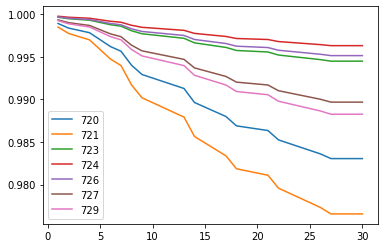

In [95]:
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)#_train, conditional_after=data_urti_no_abs_incdt_train.duration_urti_admitted)
survival_func_plot = cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)
plt.plot(survival_func_plot.loc[:, 720:729])
plt.legend(labels=survival_func_plot.loc[:, 720:729].columns, loc ="lower left")

In [96]:
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt, t0=30)

In [101]:
cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt)

,0,1,8,9,10,11,13,14,15,16,...,7107,7113,7114,7115,7116,7117,7118,7122,7124,7132
1.0,0.000425,0.000128,0.000068,0.000741,0.000172,0.000023,0.000128,0.000101,0.000144,0.000878,...,0.000081,0.000137,0.000851,0.000047,0.000329,0.000041,0.000052,0.000038,0.000066,0.000563
2.0,0.000637,0.000191,0.000103,0.001112,0.000259,0.000034,0.000191,0.000152,0.000215,0.001318,...,0.000122,0.000206,0.001277,0.000071,0.000493,0.000061,0.000079,0.000058,0.000099,0.000845
4.0,0.000851,0.000255,0.000137,0.001485,0.000345,0.000045,0.000255,0.000203,0.000288,0.001760,...,0.000162,0.000275,0.001705,0.000094,0.000658,0.000082,0.000105,0.000077,0.000132,0.001128
6.0,0.001492,0.000448,0.000240,0.002604,0.000606,0.000080,0.000448,0.000356,0.000504,0.003085,...,0.000285,0.000482,0.002990,0.000165,0.001154,0.000144,0.000184,0.000135,0.000232,0.001978
7.0,0.001707,0.000512,0.000275,0.002978,0.000693,0.000091,0.000512,0.000408,0.000577,0.003529,...,0.000326,0.000552,0.003420,0.000189,0.001320,0.000164,0.000211,0.000154,0.000265,0.002262
8.0,0.002353,0.000706,0.000379,0.004105,0.000955,0.000126,0.000706,0.000562,0.000795,0.004864,...,0.000449,0.000760,0.004715,0.000261,0.001820,0.000227,0.000290,0.000213,0.000365,0.003118
9.0,0.002784,0.000836,0.000449,0.004858,0.001130,0.000149,0.000836,0.000665,0.000941,0.005757,...,0.000531,0.000900,0.005580,0.000309,0.002154,0.000268,0.000344,0.000252,0.000432,0.003691
13.0,0.003433,0.001030,0.000553,0.005989,0.001394,0.000183,0.001030,0.000820,0.001160,0.007097,...,0.000655,0.001109,0.006879,0.000381,0.002655,0.000330,0.000423,0.000310,0.000533,0.004550
14.0,0.004084,0.001226,0.000658,0.007126,0.001658,0.000218,0.001226,0.000975,0.001380,0.008444,...,0.000779,0.001320,0.008184,0.000453,0.003159,0.000393,0.000504,0.000369,0.000634,0.005413
15.0,0.004302,0.001291,0.000693,0.007506,0.001746,0.000230,0.001291,0.001027,0.001454,0.008894,...,0.000821,0.001390,0.008620,0.000477,0.003328,0.000414,0.000531,0.000389,0.000668,0.005702


In [100]:
cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)#.min()#.min()

,0,1,8,9,10,11,13,14,15,16,...,7107,7113,7114,7115,7116,7117,7118,7122,7124,7132
1.0,0.999575,0.999873,0.999932,0.999259,0.999828,0.999977,0.999873,0.999899,0.999856,0.999122,...,0.999919,0.999863,0.999149,0.999953,0.999671,0.999959,0.999948,0.999962,0.999934,0.999437
2.0,0.999363,0.999809,0.999897,0.998889,0.999741,0.999966,0.999809,0.999848,0.999785,0.998683,...,0.999878,0.999794,0.998724,0.999929,0.999507,0.999939,0.999921,0.999942,0.999901,0.999156
4.0,0.999149,0.999745,0.999863,0.998516,0.999655,0.999955,0.999745,0.999797,0.999712,0.998242,...,0.999838,0.999725,0.998296,0.999906,0.999342,0.999918,0.999895,0.999923,0.999868,0.998873
6.0,0.998509,0.999552,0.999760,0.997400,0.999394,0.999920,0.999552,0.999644,0.999496,0.996919,...,0.999715,0.999518,0.997014,0.999835,0.998846,0.999856,0.999816,0.999865,0.999768,0.998024
7.0,0.998295,0.999488,0.999725,0.997026,0.999307,0.999909,0.999488,0.999592,0.999423,0.996477,...,0.999674,0.999448,0.996585,0.999811,0.998681,0.999836,0.999789,0.999846,0.999735,0.997740
8.0,0.997650,0.999294,0.999621,0.995904,0.999045,0.999874,0.999294,0.999438,0.999205,0.995148,...,0.999551,0.999240,0.995297,0.999739,0.998182,0.999774,0.999710,0.999787,0.999635,0.996886
9.0,0.997219,0.999165,0.999551,0.995154,0.998870,0.999851,0.999165,0.999335,0.999060,0.994260,...,0.999469,0.999100,0.994436,0.999691,0.997848,0.999732,0.999657,0.999748,0.999568,0.996316
13.0,0.996573,0.998970,0.999447,0.994029,0.998607,0.999817,0.998970,0.999181,0.998841,0.992928,...,0.999345,0.998891,0.993145,0.999619,0.997348,0.999670,0.999577,0.999690,0.999467,0.995460
14.0,0.995924,0.998775,0.999342,0.992900,0.998343,0.999782,0.998775,0.999025,0.998621,0.991592,...,0.999221,0.998681,0.991849,0.999547,0.996846,0.999607,0.999496,0.999631,0.999366,0.994601
15.0,0.995708,0.998710,0.999307,0.992522,0.998255,0.999770,0.998710,0.998973,0.998547,0.991145,...,0.999179,0.998611,0.991417,0.999523,0.996678,0.999586,0.999469,0.999611,0.999333,0.994314


In [89]:
# cph_urti_no_abs_incdt.plot_partial_effects_on_outcome(data_urti_no_abs_incdt.event_urti_admitted, values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

In [90]:
# data_urti_no_abs_incdt.loc[data_urti_no_abs_incdt.event_urti_admitted == 1]
# survival_func_plot

In [91]:
a = cph_urti_no_abs_incdt.baseline_hazard_
# cph_urti_no_abs_incdt.baseline_survival_
# cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt, data_urti_no_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_incdt.txt', a, delimiter=',')

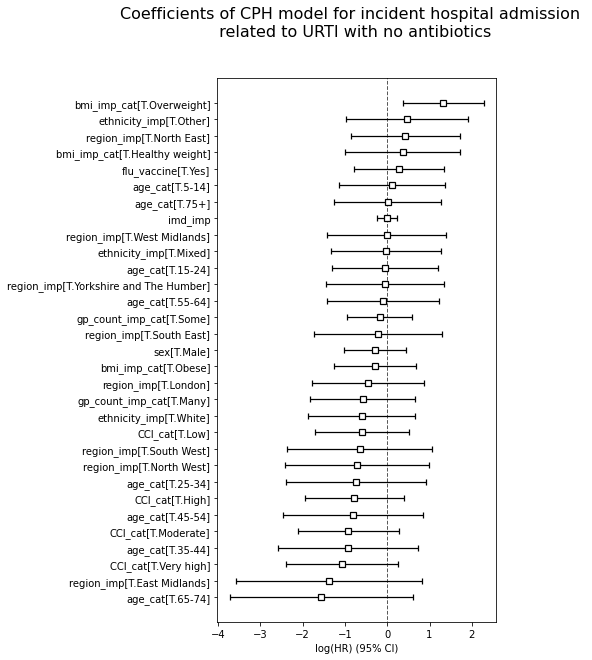

In [92]:
fig, ax = plt.subplots(figsize=(5, 10)
                        )
cph_urti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [93]:
# concordance index of cph model with testing data
concord_index_urti_no_abs_incdt_test = concordance_index(data_urti_no_abs_incdt_test['duration_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['event_urti_admitted'])
print(f'Concordance index for urti_no_abs_incdt with testing data: {concord_index_urti_no_abs_incdt_test}')
# print(concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted']))

Concordance index for urti_no_abs_incdt with testing data: 0.6194697529344169


In [94]:
a = [concord_index_urti_no_abs_incdt_test]
np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_incdt_test.txt', a, delimiter=',')

ICI =  0.0004348292627979522
E50 =  0.00031631208516691434


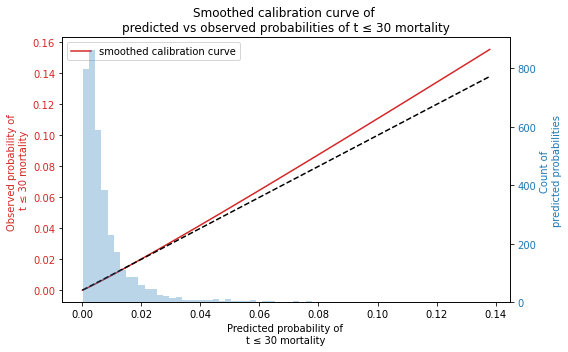

In [95]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with no antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

# t0 (float) – the time to evaluate the probability of event occurring prior at.
# ICI – mean absolute difference between predicted and observed
# E50 – median absolute difference between predicted and observed

ICI =  0.004079128504346049
E50 =  0.002926833953712682


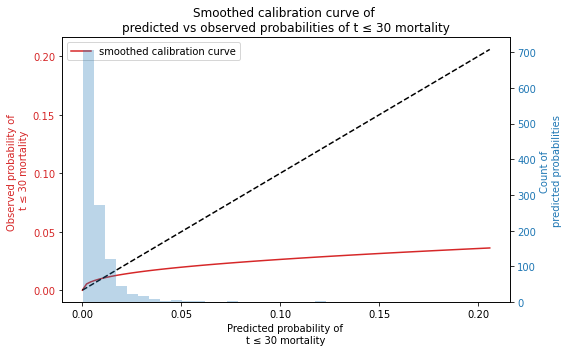

In [96]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_test, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with no antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [112]:
# print(cph_urti_no_abs_incdt.score(data_urti_no_abs_incdt_1_test))
# print(cph_urti_no_abs_incdt.concordance_index_)
# print(cph_urti_no_abs_incdt.AIC_partial_)
# print(cph_urti_no_abs_incdt.concordance_index_)

#### 4-1-2- Incident hospital admission related to URTI with antibiotics

In [83]:
data_urti_abs_incdt.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [84]:
data_urti_abs_incdt.shape

(556, 40)

In [85]:
#keep relevant variables
data_urti_abs_incdt = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                           'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                           'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                           'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                           'event_urti_admitted', 'duration_urti_admitted']]

In [86]:
# printing number of missing values in each variable 
data_urti_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [87]:
# #drop ros with missing values
# data_urti_abs_incdt = data_urti_abs_incdt.dropna(axis='rows')
# #data_urti_abs_incdt = data_urti_abs_incdt.drop(columns=['smoking_status'])
# data_urti_abs_incdt.isnull().sum()

In [88]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_train, data_urti_abs_incdt_test = train_test_split(data_urti_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_incdt for training: {data_urti_abs_incdt_train.shape}')
print(f'shape of data_urti_abs_incdt for testing: {data_urti_abs_incdt_test.shape}')

shape of data_urti_abs_incdt for training: (417, 20)
shape of data_urti_abs_incdt for testing: (139, 20)


In [89]:
cph_urti_abs_incdt = CoxPHFitter().fit(data_urti_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
        )
cph_urti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 417 total observations, 413 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 417
number of events observed = 4
   partial log-likelihood = -8.02
         time fit was run = 2022-05-09 09:10:13 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
CCI_cat[T.Low]                          -4.55       0.01       5.19           -14.71             5.62                 0.00               275.37
CCI_cat[T.Moderate]                     -4.68       0.01       5.85           -16.16             6.79                 0.00               888.65
CCI_cat[T.High]                         -3.43       0.03       3.37           -10.04             3.18                 0.00                24.05
CCI_cat[T.Very high]                    -1.72       0.18       3.15            -7.89             4.45                 0.00                85.82
age_cat[T.15-24]                        -4.27       0.01       8.24           -20.42            11.87                 0.00             1.43e+05
age_cat[T.25-34]                        -3.87       0.02       6.56           -16.73             9.00                 0.00              8071.47
age_cat[T.35-44]                        -2.78       0.06       7.90           -18.26            12.70                 0.00             3.27e+05
age_cat[T.45-54]                        -3.25       0.04       6.04           -15.10             8.59                 0.00              5390.92
age_cat[T.5-14]                         -5.96       0.00       5.14           -16.04             4.12                 0.00                61.65
age_cat[T.55-64]                        -1.27       0.28       3.67            -8.47             5.93                 0.00               375.89
age_cat[T.65-74]                        -1.16       0.31       3.66            -8.33             6.01                 0.00               408.53
age_cat[T.75+]                          -1.28       0.28       3.34            -7.83             5.27                 0.00               195.12
bmi_imp_cat[T.Healthy weight]           -0.95       0.39      10.42           -21.38            19.48                 0.00             2.88e+08
bmi_imp_cat[T.Overweight]                0.42       1.52       3.06            -5.58             6.41                 0.00               609.04
bmi_imp_cat[T.Obese]                    -1.07       0.34       3.09            -7.13             4.99                 0.00               146.85
ethnicity_imp[T.Mixed]                  -1.24       0.29       2.85            -6.83             4.36                 0.00                78.09
ethnicity_imp[T.Other]                  -4.43       0.01       8.86           -21.80            12.94                 0.00             4.17e+05
ethnicity_imp[T.White]                  -4.15       0.02       2.90            -9.84             1.53                 0.00                 4.64
flu_vaccine[T.Yes]                       2.71      15.00       3.30            -3.76             9.17                 0.02              9636.67
gp_count_imp_cat[T.Some]                 2.20       9.06       2.69            -3.06             7.47                 0.05              1754.83
gp_count_imp_cat[T.Many]                 1.60       4.94       5.15            -8.50            11.70                 0.00             1.20e+05
imd_imp                                  0.42       1.52       0.87            -1.30             2.13                 0.27                 8.43
region_imp[T.East Midlands]              3.88      48.31       7.73           -11.26            19.02                 0.00             1.82e+08
region_imp[T.Lo

In [90]:
output = GetPrintSummary(cph_urti_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

12430


In [91]:
a = cph_urti_abs_incdt.baseline_hazard_
# cph_urti_abs_incdt.baseline_survival_
# cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt, data_urti_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_abs_incdt.predict_survival_function(data_urti_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_abs_incdt.txt', a, delimiter=',')

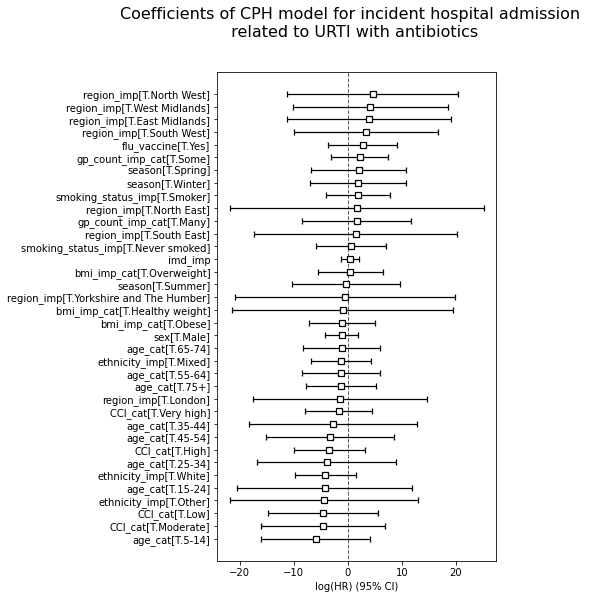

In [92]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [93]:
# concordance index of cph model with testing data
concord_index_urti_abs_incdt_test = concordance_index(data_urti_abs_incdt_test['duration_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_test), data_urti_abs_incdt_test['event_urti_admitted'])
print(f'Concordance index for urti_abs_incdt with testing data: {concord_index_urti_abs_incdt_test}')

Concordance index for urti_abs_incdt with testing data: 0.635036496350365


In [94]:
a = [concord_index_urti_abs_incdt_test]
np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_incdt_test.txt', a, delimiter=',')

ICI =  0.01002351235311675
E50 =  2.404106353537383e-05


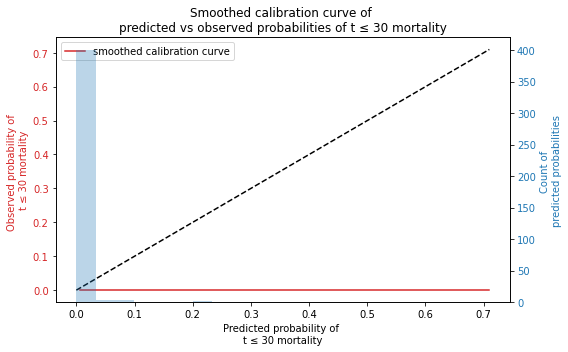

In [95]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

ICI =  0.008958099502569596
E50 =  2.4825834076314113e-05


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 30 mortality'}, xlabel='Predicted probability of \nt ≤ 30 mortality', ylabel='Observed probability of \nt ≤ 30 mortality'>,
 0.008958099502569596,
 2.4825834076314113e-05)

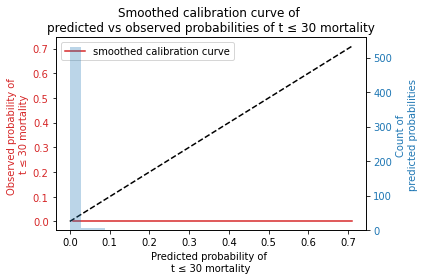

In [96]:
survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt, t0=30)

ICI =  0.01002351235311675
E50 =  2.404106353537383e-05


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 30 mortality'}, xlabel='Predicted probability of \nt ≤ 30 mortality', ylabel='Observed probability of \nt ≤ 30 mortality'>,
 0.01002351235311675,
 2.404106353537383e-05)

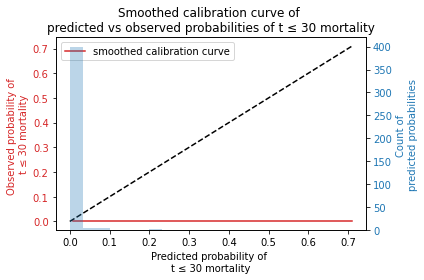

In [97]:
survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)

ICI =  0.005761410298756637
E50 =  3.1588752297362355e-05


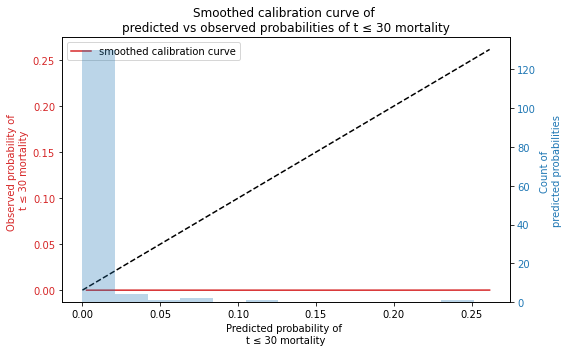

In [98]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_test, t0=30)
# plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

#### 4-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [99]:
data_urti_no_abs_prevl.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [100]:
data_urti_no_abs_prevl.shape

(572, 40)

In [101]:
#keep relevant variables
data_urti_no_abs_prevl = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                                 'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                                 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [102]:
# printing number of missing values in each variable 
data_urti_no_abs_prevl.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [103]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test = train_test_split(data_urti_no_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_prevl for training: {data_urti_no_abs_prevl_train.shape}')
print(f'shape of data_urti_no_abs_prevl for testing: {data_urti_no_abs_prevl_test.shape}')

shape of data_urti_no_abs_prevl for training: (429, 20)
shape of data_urti_no_abs_prevl for testing: (143, 20)


In [104]:
cph_urti_no_abs_prevl = CoxPHFitter().fit(data_urti_no_abs_prevl_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
        )
cph_urti_no_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 429 total observations, 422 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 429
number of events observed = 7
   partial log-likelihood = -20.55
         time fit was run = 2022-05-09 09:10:21 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
CCI_cat[T.Low]                          15.29   4.37e+06   16241.16        -31816.79         31847.37                 0.00                  inf
CCI_cat[T.Moderate]                     15.55   5.68e+06   16241.16        -31816.53         31847.63                 0.00                  inf
CCI_cat[T.High]                         17.40   3.60e+07   16241.16        -31814.68         31849.48                 0.00                  inf
CCI_cat[T.Very high]                    23.76   2.07e+10   16241.16        -31808.33         31855.84                 0.00                  inf
age_cat[T.15-24]                       -23.78       0.00    9920.47        -19467.53         19419.98                 0.00                  inf
age_cat[T.25-34]                       -21.45       0.00   10733.11        -21057.97         21015.07                 0.00                  inf
age_cat[T.35-44]                         2.64      14.05       2.09            -1.45             6.74                 0.23               843.59
age_cat[T.45-54]                         3.44      31.27       2.21            -0.89             7.77                 0.41              2379.84
age_cat[T.5-14]                        -13.73       0.00   16234.51        -31832.79         31805.33                 0.00                  inf
age_cat[T.55-64]                        -0.24       0.79       2.17            -4.48             4.01                 0.01                55.13
age_cat[T.65-74]                       -17.81       0.00   10512.97        -20622.84         20587.23                 0.00                  inf
age_cat[T.75+]                           1.18       3.24       2.84            -4.39             6.74                 0.01               847.01
bmi_imp_cat[T.Healthy weight]           24.09   2.89e+10    6204.38        -12136.28         12184.45                 0.00                  inf
bmi_imp_cat[T.Overweight]               25.30   9.67e+10    6204.38        -12135.07         12185.66                 0.00                  inf
bmi_imp_cat[T.Obese]                    21.69   2.62e+09    6204.38        -12138.68         12182.05                 0.00                  inf
ethnicity_imp[T.Mixed]                  14.64   2.29e+06   13220.67        -25897.40         25926.69                 0.00                  inf
ethnicity_imp[T.Other]                  -4.77       0.01   16923.44        -33174.11         33164.57                 0.00                  inf
ethnicity_imp[T.White]                  14.67   2.36e+06   13220.67        -25897.37         25926.72                 0.00                  inf
flu_vaccine[T.Yes]                     -23.57       0.00   12999.08        -25501.29         25454.16                 0.00                  inf
gp_count_imp_cat[T.Some]                -2.83       0.06       3.16            -9.03             3.36                 0.00                28.92
gp_count_imp_cat[T.Many]                 2.13       8.44       2.33            -2.44             6.71                 0.09               818.34
imd_imp                                  1.41       4.11       0.88            -0.32             3.14                 0.73                23.17
region_imp[T.East Midlands]             -2.51       0.08   21689.05        -42512.26         42507.24                 0.00                  inf
region_imp[T.L

In [105]:
output = GetPrintSummary(cph_urti_no_abs_prevl)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

12625


In [106]:
a = cph_urti_no_abs_prevl.baseline_hazard_
# cph_urti_no_abs_prevl.baseline_survival_
# cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl, data_urti_no_abs_prevl['duration_urti_admitted']<=30)
# cph_urti_no_abs_prevl.predict_survival_function(data_urti_no_abs_prevl)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_prevl.txt', a, delimiter=',')

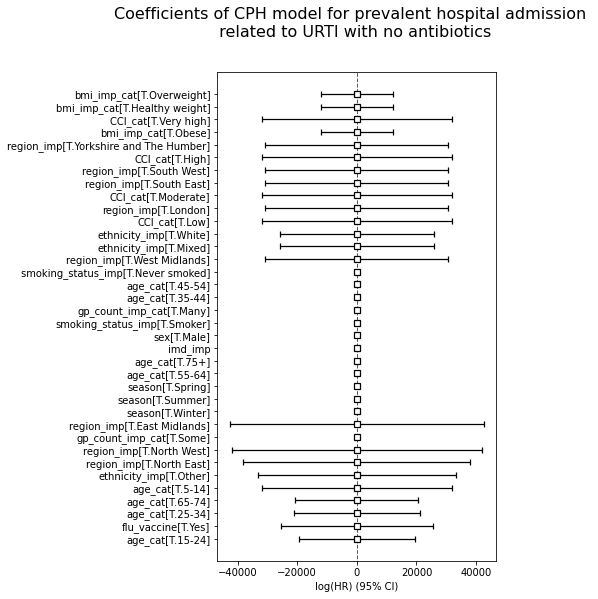

In [107]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_no_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [108]:
# data_urti_no_abs_prevl_test.columns

In [124]:
# concordance index of cph model with testing data
concord_index_urti_no_abs_prevl_test = concordance_index(data_urti_no_abs_prevl_test['duration_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_test), data_urti_no_abs_prevl_test['event_urti_admitted'])
print(f'Concordance index for cph_urti_no_abs_prevl with testing data: {concord_index_urti_no_abs_prevl_test}')

In [ ]:
a = [concord_index_urti_no_abs_prevl_test]
np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_prevl_test.txt', a, delimiter=',')

ICI =  0.007171901710415653
E50 =  3.9823433439778455e-10


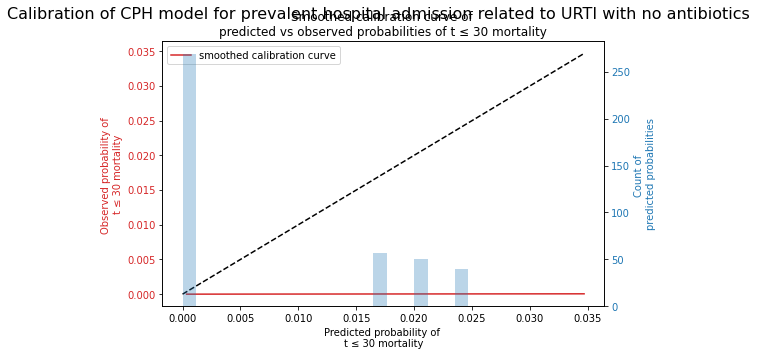

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

#### 4-1-4- Prevalent hospital admission related to URTI with antibiotics

In [ ]:
data_urti_abs_prevl.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [ ]:
#keep relevant variables
data_urti_abs_prevl = data_urti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                           'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                           'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                           'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                           'event_urti_admitted', 'duration_urti_admitted']]

In [ ]:
# print number of missing values in each variable 
data_urti_abs_prevl.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               0
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [115]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_prevl_train, data_urti_abs_prevl_test = train_test_split(data_urti_abs_prevl, test_size=0.2)

print(f'shape of data_urti_abs_prevl for training: {data_urti_abs_prevl_train.shape}')
print(f'shape of data_urti_abs_prevl for testing: {data_urti_abs_prevl_test.shape}')

shape of data_urti_abs_prevl for training: (53, 40)
shape of data_urti_abs_prevl for testing: (14, 40)


In [117]:
cph_urti_abs_prevl = CoxPHFitter().fit(data_urti_abs_prevl_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
        )
cph_urti_abs_prevl.print_summary()

In [118]:
output = GetPrintSummary(cph_urti_abs_prevl)

with open('../output/hospitalisation_prediction_urti/cph_urti_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

In [119]:
a = cph_urti_abs_prevl.baseline_hazard_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_abs_prevl.txt', a, delimiter=',')

In [120]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_no_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [121]:
# concordance index of cph model with testing data
concord_index_urti_abs_prevl_test = concordance_index(data_urti_abs_prevl_test['duration_urti_admitted'], -cph_urti_abs_prevl.predict_partial_hazard(data_urti_abs_prevl_test), data_urti_abs_prevl_test['event_urti_admitted'])
print(f'Concordance index for cph_urti_abs_prevl with testing data: {concord_index_urti_abs_prevl_test}')

In [122]:
a = [concord_index_urti_abs_prevl_test]
np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_prevl_test.txt', a, delimiter=',')

In [123]:
fig, ax = plt.subplots(figsize=(8, 5)
                        )
survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_abs_prevl_train, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

## 4- Logistic regression modelling

In [619]:
data_urti.head()

,Age_cat,msoa,age,age_cat,sex,bmi_imp,bmi_imp_cat,gp_count,gp_count_imp_cat,gp_count_imp,...,sgss_gp_cov_urti_date,date,season,date_month,event_urti_admitted,delta_urti_admitted,delta_admitted_died,delta_admitted_deregistered,delta_admitted_died_deregistered,duration_urti_admitted
0,>59 years,E02000002,75,25-34,Male,31.958280,Obese,9.0,Many,9.0,...,0,2019-09,Autumn,9,0.0,NaN,NaN,NaN,NaN,30.0
1,18-59 years,E02000002,54,45-54,Female,34.540100,Obese,4.0,Some,4.0,...,0,2020-11,Autumn,11,0.0,NaN,NaN,NaN,NaN,30.0
2,>59 years,E02000001,77,75+,Male,40.250092,Obese,0.0,Few,0.0,...,0,2021-01,Winter,1,0.0,NaN,NaN,NaN,NaN,30.0
3,18-59 years,E02000002,40,25-34,Male,40.896268,Obese,1.0,Few,1.0,...,0,2021-06,Summer,6,0.0,NaN,NaN,NaN,NaN,30.0
4,>59 years,E02000001,62,75+,Female,35.009585,Obese,9.0,Many,9.0,...,0,2019-05,Spring,5,0.0,NaN,NaN,NaN,NaN,30.0


In [646]:
#translating categories of variables into lr-friendly integers!

data_urti_lr = data_urti

dict_sex = {'Female':"1", 'Male':"2"}
data_urti_lr = data_urti_lr.replace({"sex": dict_sex})

# data_urti_lr['Age_cat'] = pd.cut(data_urti['age'], right=False, bins=[0,5,15,25,35,45,55,65,75,130], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_age_cat = {'0-4':"1", '5-14':"2", '15-24':"3", '25-34':"4", '35-44':"5", '45-54':"6", '55-64':"7", '65-74':"8", '75+':"9"}
data_urti_lr = data_urti_lr.replace({"age_cat": dict_age_cat})

dict_bmi = {'Underweight':1, 'Healthy weight':2, 'Overweight':3, 'Obese':4}
data_urti_lr = data_urti_lr.replace({"bmi_imp_cat": dict_bmi})

dict_cci = {'No':1, 'Low':2, 'Moderate':3, 'High':4, 'Very high':5}
data_urti_lr = data_urti_lr.replace({"CCI_cat": dict_cci})

dict_gp = {'Few':1, 'Some':2, 'Many':3}
data_urti_lr = data_urti_lr.replace({"gp_count_imp_cat": dict_gp})

dict_flu = {'No':1, 'Yes':2}
data_urti_lr = data_urti_lr.replace({"flu_vaccine": dict_flu})

dict_region = {'London':1, 'East':2, 'South East':3, 'Yorkshire and The Humber':4, 'South West':5, 'North West':6, 'North East':7, 'West Midlands':8, 'East Midlands':9}
data_urti_lr = data_urti_lr.replace({"region_imp": dict_region})

dict_imd = {'0':1, '1':2, '2':3, '3':4, '4':5, '5':6}
data_urti_lr = data_urti_lr.replace({"imd_imp": dict_imd})

dict_ethnicity = {'White':1, 'Mixed':2, 'Asian':3, 'Black':4, 'Other':5}
data_urti_lr = data_urti_lr.replace({"ethnicity_imp": dict_ethnicity})

dict_smoking = {'Ex-smoker':1, 'Smoker':2, 'Never smoked':3}
data_urti_lr = data_urti_lr.replace({"smoking_status_imp": dict_smoking})

dict_season = {'Spring':1, 'Summer':2, 'Autumn':3, 'Winter':4}
data_urti_lr = data_urti_lr.replace({"season": dict_season})

data_urti_lr['antibacterial_brit_cat'] = pd.cut(data_urti_lr['antibacterial_brit_imp'], right=False, bins=[0,1,4,10000000000], labels=[1, 2, 3])

data_urti_lr['meds_nonabs_cat'] = pd.cut(data_urti_lr['meds_nonabs'], right=False, bins=[0,1,4,10000000000], labels=[1, 2, 3])

data_urti_lr.head()

,Age_cat,msoa,age,age_cat,sex,bmi_imp,bmi_imp_cat,gp_count,gp_count_imp_cat,gp_count_imp,...,sgss_gp_cov_urti_date,date,season,date_month,event_urti_admitted,delta_urti_admitted,delta_admitted_died,delta_admitted_deregistered,delta_admitted_died_deregistered,duration_urti_admitted
0,>59 years,E02000002,75,4,2,31.958280,4,9.0,3,9.0,...,0,2019-09,3,9,0.0,NaN,NaN,NaN,NaN,30.0
1,18-59 years,E02000002,54,6,1,34.540100,4,4.0,2,4.0,...,0,2020-11,3,11,0.0,NaN,NaN,NaN,NaN,30.0
2,>59 years,E02000001,77,9,2,40.250092,4,0.0,1,0.0,...,0,2021-01,4,1,0.0,NaN,NaN,NaN,NaN,30.0
3,18-59 years,E02000002,40,4,2,40.896268,4,1.0,1,1.0,...,0,2021-06,2,6,0.0,NaN,NaN,NaN,NaN,30.0
4,>59 years,E02000001,62,9,1,35.009585,4,9.0,3,9.0,...,0,2019-05,1,5,0.0,NaN,NaN,NaN,NaN,30.0


In [647]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt_lr = data_urti_lr[data_urti_lr['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt_lr = data_urti_no_abs_incdt_lr[data_urti_no_abs_incdt_lr['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt_lr = data_urti_lr[data_urti_lr['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt_lr = data_urti_abs_incdt_lr[data_urti_abs_incdt_lr['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl_lr = data_urti_lr[data_urti_lr['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl_lr = data_urti_no_abs_prevl_lr[data_urti_no_abs_prevl_lr['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl_lr = data_urti_lr[data_urti_lr['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl_lr = data_urti_abs_prevl_lr[data_urti_abs_prevl_lr['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt_lr: {data_urti_no_abs_incdt_lr.shape}')
print(f'shape of data_urti_abs_incdt_lr: {data_urti_abs_incdt_lr.shape}')
print(f'shape of data_urti_no_abs_prevl_lr: {data_urti_no_abs_prevl_lr.shape}')
print(f'shape of data_urti_abs_prevl_lr: {data_urti_abs_prevl_lr.shape}')

shape of data_urti_no_abs_incdt_lr: (4948, 40)
shape of data_urti_abs_incdt_lr: (556, 40)
shape of data_urti_no_abs_prevl_lr: (572, 40)
shape of data_urti_abs_prevl_lr: (67, 40)


### 4-1 Incident URTI with no antibiotics

In [648]:
data_urti_no_abs_incdt.head()

,Age_cat,msoa,age,age_cat,sex,bmi_imp,bmi_imp_cat,gp_count,gp_count_imp_cat,gp_count_imp,...,sgss_gp_cov_urti_date,date,season,date_month,event_urti_admitted,delta_urti_admitted,delta_admitted_died,delta_admitted_deregistered,delta_admitted_died_deregistered,duration_urti_admitted
0,>59 years,E02000002,75,25-34,Male,31.958280,Obese,9.0,Many,9.0,...,0,2019-09,Autumn,9,0.0,NaN,NaN,NaN,NaN,30.0
1,18-59 years,E02000002,54,45-54,Female,34.540100,Obese,4.0,Some,4.0,...,0,2020-11,Autumn,11,0.0,NaN,NaN,NaN,NaN,30.0
2,>59 years,E02000001,77,75+,Male,40.250092,Obese,0.0,Few,0.0,...,0,2021-01,Winter,1,0.0,NaN,NaN,NaN,NaN,30.0
3,18-59 years,E02000002,40,25-34,Male,40.896268,Obese,1.0,Few,1.0,...,0,2021-06,Summer,6,0.0,NaN,NaN,NaN,NaN,30.0
4,>59 years,E02000001,62,75+,Female,35.009585,Obese,9.0,Many,9.0,...,0,2019-05,Spring,5,0.0,NaN,NaN,NaN,NaN,30.0


In [623]:
data_urti_no_abs_incdt_lr = data_urti_no_abs_incdt[['sex', 
                                                      'age_cat', 'CCI_cat', 'gp_count_imp_cat', 'flu_vaccine', 'bmi_imp_cat', 'region_imp', 'imd_imp', 
                                                      'ethnicity_imp', 'smoking_status_imp', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 
                                                      'event_urti_admitted']]

# data_urti_no_abs_incdt_lr_X = data_urti_no_abs_incdt[['sex', 
#                                                         'age_cat', 'CCI_cat', 'gp_count_imp_cat', 'flu_vaccine', 'bmi_imp_cat', 'region_imp', 'imd_imp', 'ethnicity_imp', 'smoking_status_imp', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 
#                                                     ]]

# data_urti_no_abs_incdt_lr_y = data_urti_no_abs_incdt[['event_urti_admitted']]

data_urti_no_abs_incdt_lr.head()
# data_urti_no_abs_incdt_lr_X.head()

,sex,age_cat,CCI_cat,gp_count_imp_cat,flu_vaccine,bmi_imp_cat,region_imp,imd_imp,ethnicity_imp,smoking_status_imp,season,antibacterial_brit_cat,meds_nonabs_cat,event_urti_admitted
0,Male,25-34,High,Many,No,Obese,South East,4,White,Ex-smoker,Autumn,Some,Few,0.0
1,Female,45-54,High,Some,No,Obese,South East,5,White,Ex-smoker,Autumn,Some,Few,0.0
2,Male,75+,High,Few,No,Obese,East Midlands,5,Mixed,Ex-smoker,Winter,Few,Few,0.0
3,Male,25-34,Low,Few,No,Obese,South East,2,Mixed,Smoker,Summer,Few,Few,0.0
4,Female,75+,Very high,Many,No,Obese,West Midlands,1,White,Ex-smoker,Spring,Few,Few,0.0


In [627]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_lr_train, data_urti_no_abs_incdt_lr_test = train_test_split(data_urti_no_abs_incdt_lr, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt_lr for training: {data_urti_no_abs_incdt_lr_train.shape}')
print(f'shape of data_urti_no_abs_incdt_lr for testing: {data_urti_no_abs_incdt_lr_test.shape}')

shape of data_urti_no_abs_incdt_lr for training: (3711, 14)
shape of data_urti_no_abs_incdt_lr for testing: (1237, 14)


In [486]:
# # X = data_urti_no_abs_incdt_lr_X('event_urti_admitted', axis = 1).values
# X = data_urti_no_abs_incdt_lr_X.values

# y = data_urti_no_abs_incdt_lr_y.event_urti_admitted
# y = y.astype(int)

# #randomly splitting data into training (%75) and testing (%25)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# print(f'shape of X_train: {X_train.shape}')
# print(f'shape of X_test: {X_test.shape}')
# print(f'shape of y_train: {y_train.shape}')
# print(f'shape of y_testg: {y_test.shape}')

shape of X_train: (3711, 1)
shape of X_test: (1237, 1)
shape of y_train: (3711,)
shape of y_testg: (1237,)


In [335]:
#build LR model
lr_urti_no_abs_incdt = LogisticRegression().fit(data_urti_no_abs_incdt_lr_train[['age_cat', 'sex', 'CCI_cat', 'gp_count_imp_cat', 'flu_vaccine', 'bmi_imp_cat', 'region_imp', 'imd_imp', 'ethnicity_imp', 'smoking_status_imp', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']], data_urti_no_abs_incdt_lr_train.event_urti_admitted)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_no_abs_incdt_train = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_train[['age_cat', 'sex', 'CCI_cat', 'gp_count_imp_cat', 'flu_vaccine', 'bmi_imp_cat', 'region_imp', 'imd_imp', 'ethnicity_imp', 'smoking_status_imp', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']])
# pred_proba_urti_no_abs_incdt_train

#calculate score of lr_urti_no_abs_incdt with training data
lr_urti_no_abs_incdt_training_score = lr_urti_no_abs_incdt.score(data_urti_no_abs_incdt_lr_train[['age_cat', 'sex', 'CCI_cat', 'gp_count_imp_cat', 'flu_vaccine', 'bmi_imp_cat', 'region_imp', 'imd_imp', 'ethnicity_imp', 'smoking_status_imp', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']], data_urti_no_abs_incdt_lr_train.event_urti_admitted)
print(f'score of lr_urti_no_abs_incdt with training data: {lr_urti_no_abs_incdt_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_no_abs_incdt_test = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_test[['age_cat', 'sex', 'CCI_cat', 'gp_count_imp_cat', 'flu_vaccine', 'bmi_imp_cat', 'region_imp', 'imd_imp', 'ethnicity_imp', 'smoking_status_imp', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']])
# pred_proba_urti_no_abs_incdt_test

#calculate score of lr_urti_no_abs_incdt with testing data
lr_urti_no_abs_incdt_testing_score = lr_urti_no_abs_incdt.score(data_urti_no_abs_incdt_lr_test[['age_cat', 'sex', 'CCI_cat', 'gp_count_imp_cat', 'flu_vaccine', 'bmi_imp_cat', 'region_imp', 'imd_imp', 'ethnicity_imp', 'smoking_status_imp', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']], data_urti_no_abs_incdt_lr_test.event_urti_admitted)
print(f'score of lr_urti_no_abs_incdt with testing data: {lr_urti_no_abs_incdt_testing_score}')


score of lr_urti_no_abs_incdt with training data: 0.9927243330638642
score of lr_urti_no_abs_incdt with testing data: 0.9894907033144705


In [339]:
lr_urti_no_abs_incdt.coef_

array([[-0.01917677, -0.38902871, -0.13734659,  0.21964794,  0.27978698,
        -0.04662621,  0.01820904, -0.04707971, -0.19443311, -0.15312064,
         0.26382511, -0.27209173, -0.33091036]])

In [211]:
#predict confidence scores for each individual row of 
a = lr_urti_no_abs_incdt.decision_function(data_urti_no_abs_incdt_lr_test[['age_cat', 'sex', 'CCI_cat', 'gp_count_imp_cat', 'flu_vaccine', 'bmi_imp_cat', 'region_imp', 'imd_imp', 'ethnicity_imp', 'smoking_status_imp', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']])
# len(a)
a

array([-5.34162546, -5.01798343, -5.45410643, ..., -4.66748476,
       -5.4204297 , -6.63048531])

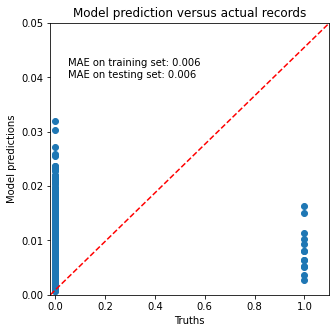

In [268]:
from sklearn.metrics import median_absolute_error

y_pred = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_train[['age_cat', 'sex', 'CCI_cat', 'gp_count_imp_cat', 'flu_vaccine', 'bmi_imp_cat', 'region_imp', 'imd_imp', 'ethnicity_imp', 'smoking_status_imp', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']])[:,1]

mae = median_absolute_error(data_urti_no_abs_incdt_lr_train.event_urti_admitted, y_pred)
string_score = f"MAE on training set: {mae:.3f}"
y_pred = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_test[['age_cat', 'sex', 'CCI_cat', 'gp_count_imp_cat', 'flu_vaccine', 'bmi_imp_cat', 'region_imp', 'imd_imp', 'ethnicity_imp', 'smoking_status_imp', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat']])[:,1]
mae = median_absolute_error(data_urti_no_abs_incdt_lr_test.event_urti_admitted, y_pred)
string_score += f"\nMAE on testing set: {mae:.3f}"
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data_urti_no_abs_incdt_lr_test.event_urti_admitted, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(0.05, 0.04, string_score)
plt.title("Model prediction versus actual records")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([-0.02, 1.1])
_ = plt.ylim([0, 0.05])

In [281]:
lr_urti_no_abs_incdt.coef_

array([[-0.01917677, -0.38902871, -0.13734659,  0.21964794,  0.27978698,
        -0.04662621,  0.01820904, -0.04707971, -0.19443311, -0.15312064,
         0.26382511, -0.27209173, -0.33091036]])

In [283]:
pred_proba_urti_no_abs_incdt_test[:,1]

array([0.00476527, 0.00657435, 0.00426047, ..., 0.00930841, 0.00440575,
       0.00131778])

In [284]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import brier_score_loss

In [296]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_no_abs_incdt_lr_train.event_urti_admitted, pred_proba_urti_no_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_no_abs_incdt_lr_test.event_urti_admitted, pred_proba_urti_no_abs_incdt_test[:,1])

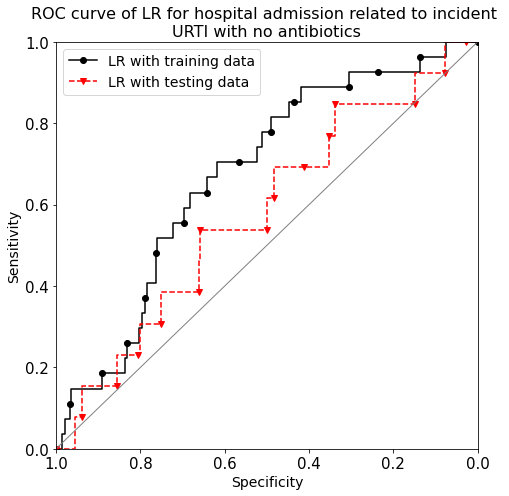

In [297]:
fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')


squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1)
plt.xlim(0,1)

#plt.title('ROC Curve')
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of LR for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
# plt.savefig('ROC_curve_adr.png', dpi=600)
plt.show()

In [298]:
r_auc1 = roc_auc_score(data_urti_no_abs_incdt_lr_train.event_urti_admitted, pred_proba_urti_no_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_urti_no_abs_incdt_lr_test.event_urti_admitted, pred_proba_urti_no_abs_incdt_test[:,1])

print('AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2))

AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = 0.6736
AUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = 0.5783


In [300]:
brier1 = brier_score_loss(data_urti_no_abs_incdt_lr_train.event_urti_admitted, pred_proba_urti_no_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_urti_no_abs_incdt_lr_test.event_urti_admitted, pred_proba_urti_no_abs_incdt_test[:,1])

print('Brier score of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2))

Brier score of LR with training data of hospital admission related to incident URTI with no antibiotics = 0.0072
Brier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = 0.0104


In [327]:
feature_names = lr_urti_no_abs_incdt.feature_names_in_
coef = np.squeeze(lr_urti_no_abs_incdt.coef_)

coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
coef_lr

,Coefficients
age_cat,-0.019177
sex,-0.389029
CCI_cat,-0.137347
gp_count_imp_cat,0.219648
flu_vaccine,0.279787
bmi_imp_cat,-0.046626
region_imp,0.018209
imd_imp,-0.047080
ethnicity_imp,-0.194433
smoking_status_imp,-0.153121


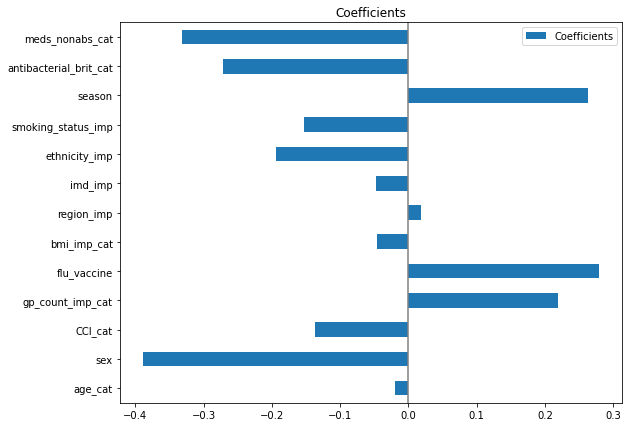

In [348]:
coef_lr.plot(kind="barh", figsize=(9, 7))
plt.title("Coefficients")
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)

In [415]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

X = survey.data[survey.feature_names]
X

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married
...,...,...,...,...,...,...,...,...,...,...
529,18.0,no,male,5.0,not_member,29.0,White,Professional,Other,Unmarried
530,12.0,no,female,33.0,not_member,51.0,Other,Professional,Other,Married
531,17.0,no,female,25.0,member,48.0,Other,Professional,Other,Married
532,12.0,yes,male,13.0,member,31.0,White,Professional,Other,Married


In [416]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [417]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
204,16.0,no,female,6.0,not_member,28.0,White,Management,Manufacturing,Married
196,16.0,no,female,26.0,not_member,48.0,White,Management,Other,Married
510,17.0,no,female,14.0,not_member,37.0,White,Professional,Other,Married
19,12.0,no,male,33.0,not_member,51.0,White,Other,Other,Married
361,16.0,no,male,21.0,not_member,43.0,White,Service,Other,Married
...,...,...,...,...,...,...,...,...,...,...
71,14.0,no,male,20.0,member,40.0,White,Other,Other,Married
106,14.0,no,male,21.0,member,41.0,White,Other,Other,Married
270,12.0,no,female,38.0,not_member,56.0,White,Clerical,Other,Married
435,18.0,no,male,8.0,not_member,32.0,White,Professional,Other,Married


In [426]:
y

array([ 5.1 ,  4.95,  6.67,  4.  ,  7.5 , 13.07,  4.45, 19.47, 13.28,
        8.75, 11.35, 11.5 ,  6.5 ,  6.25, 19.98,  7.3 ,  8.  , 22.2 ,
        3.65, 20.55,  5.71,  7.  ,  3.75,  4.5 ,  9.56,  5.75,  9.36,
        6.5 ,  3.35,  4.75,  8.9 ,  4.  ,  4.7 ,  5.  ,  9.25, 10.67,
        7.61, 10.  ,  7.5 , 12.2 ,  3.35, 11.  , 12.  ,  4.85,  4.3 ,
        6.  , 15.  ,  4.85,  9.  ,  6.36,  9.15, 11.  ,  4.5 ,  4.8 ,
        4.  ,  5.5 ,  8.4 ,  6.75, 10.  ,  5.  ,  6.5 , 10.75,  7.  ,
       11.43,  4.  ,  9.  , 13.  , 12.22,  6.28,  6.75,  3.35, 16.  ,
        5.25,  3.5 ,  4.22,  3.  ,  4.  , 10.  ,  5.  , 16.  , 13.98,
       13.26,  6.1 ,  3.75,  9.  ,  9.45,  5.5 ,  8.93,  6.25,  9.75,
        6.73,  7.78,  2.85,  3.35, 19.98,  8.5 ,  9.75, 15.  ,  8.  ,
       11.25, 14.  , 10.  ,  6.5 ,  9.83, 18.5 , 12.5 , 26.  , 14.  ,
       10.5 , 11.  , 12.47, 12.5 , 15.  ,  6.  ,  9.5 ,  5.  ,  3.75,
       12.57,  6.88,  5.5 ,  7.  ,  4.5 ,  6.5 , 12.  ,  5.  ,  6.5 ,
        6.8 ,  8.75,

In [420]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['RACE', 'OCCUPATION', 'SECTOR', 'MARR',
                                  'UNION', 'SEX', 'SOUTH'])],
                  verbose_feature_names_out=False)

In [421]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

# sp = spotipy.Spotify()

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

In [422]:
_ = model.fit(X_train, y_train)

In [423]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
RACE_Hispanic,-0.013520
RACE_Other,-0.009076
RACE_White,0.022593
OCCUPATION_Clerical,0.000080
OCCUPATION_Management,0.090563
OCCUPATION_Other,-0.025066
OCCUPATION_Professional,0.071999
OCCUPATION_Sales,-0.046601
OCCUPATION_Service,-0.091018
SECTOR_Construction,-0.000179


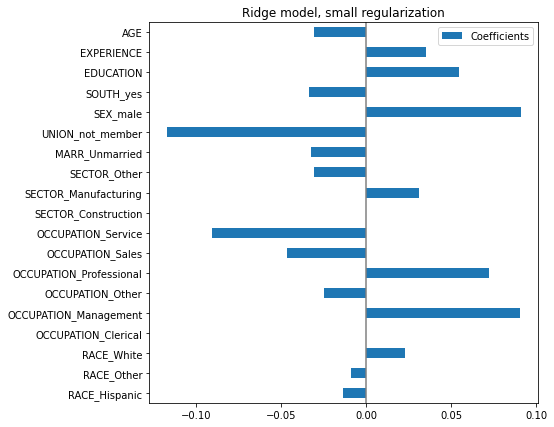

In [376]:
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)